In [1]:
BATCH_SIZE = 2
EPOCH_COUNT = 25
NUM_LOADER_WORKERS = 4

In [2]:
import os
import random
import math
import csv

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import torch
from torch.utils.data import Dataset as BaseDataset
import torchvision
import albumentations

import rasterio
import segmentation_models_pytorch as smp

In [4]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(4)

[ Using Seed :  4  ]


In [5]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
force_cudnn_initialization()

In [6]:
# Configure data paths
DATA_PATH = '/home/user3/work/data/tiles_ulaanbaatar_x1024'

In [7]:
image_file_postfix = '_im.tif'
polygon_file_postfix = '_pl.tif'


def split_count(count, fraction):
    fraction_count = int(count * fraction)
    num_set = [i for i in range(count)]
    random.shuffle(num_set)
    return num_set[:fraction_count], num_set[fraction_count:]


def get_folder_list(dataset_path):
    folder_list = [os.path.join(dataset_path, fn) for fn in os.listdir(dataset_path)
                   if os.path.isdir(os.path.join(dataset_path, fn))]
    folder_list = sorted(folder_list)
    return folder_list


def load_dataset(folder_list):
    folder_list = sorted(folder_list)
    result = []
    for folder in folder_list:
        file_list = [os.path.join(folder, fn) for fn in os.listdir(folder) if os.path.isfile(os.path.join(folder, fn))]
        
        # Get list of tiles
        unique_names = [fp for fp in file_list if fp.endswith(image_file_postfix)]
        unique_names = [os.path.basename(fp)[:-len(image_file_postfix)] for fp in unique_names]
        for name in unique_names:
            path_list = [
                os.path.join(folder, name + image_file_postfix),
                os.path.join(folder, name + polygon_file_postfix),
            ]
            if not all([os.path.exists(i) for i in path_list]):
                raise ValueError('Invalid path in list ' + str(path_list))
            result.append(path_list)
    return result

In [8]:
# Load dataset
valid_set = [('3', '0_3_im.tif'),
 ('4', '1_2_im.tif'),
 ('21', '0_0_im.tif'),
 ('41', '0_1_im.tif'),
 ('36', '1_2_im.tif'),
 ('3', '0_0_im.tif'),
 ('29', '0_3_im.tif'),
 ('8', '1_2_im.tif'),
 ('41', '1_0_im.tif'),
 ('18', '3_1_im.tif'),
 ('6', '3_2_im.tif'),
 ('2', '3_3_im.tif'),
 ('36', '2_3_im.tif'),
 ('3', '2_0_im.tif'),
 ('3', '2_1_im.tif'),
 ('41', '0_0_im.tif'),
 ('41', '2_0_im.tif'),
 ('23', '1_0_im.tif'),
 ('41', '0_3_im.tif'),
 ('8', '0_1_im.tif'),
 ('6', '2_3_im.tif'),
 ('1', '3_0_im.tif'),
 ('5', '2_0_im.tif'),
 ('3', '1_1_im.tif'),
 ('1', '2_2_im.tif'),
 ('29', '0_0_im.tif'),
 ('19', '1_1_im.tif'),
 ('3', '1_2_im.tif'),
 ('3', '3_1_im.tif'),
 ('2', '3_0_im.tif'),
 ('6', '3_0_im.tif'),
 ('41', '0_2_im.tif'),
 ('6', '1_3_im.tif')]

folder_list = get_folder_list(DATA_PATH)

tiles = load_dataset(folder_list)

train_tiles = [i for i in tiles if (str.split(os.path.dirname(i[0]), '/')[-1], os.path.basename(i[0])) not in valid_set]
valid_tiles = [i for i in tiles if (str.split(os.path.dirname(i[0]), '/')[-1], os.path.basename(i[0])) in valid_set]

print(len(train_tiles))
print(len(valid_tiles))

78
33


In [9]:
class Dataset(BaseDataset):
    
    def __init__(
        self, 
        dataset_tiles,
        augmentation=None, 
    ):
        self.dataset_tiles = dataset_tiles
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image_p, mask_p = self.dataset_tiles[i]
            
        image = cv2.imread(image_p, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_p).clip(0, 1)[:,:,0].astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.dataset_tiles)

In [10]:
train_augumentations = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.50),
    albumentations.RandomRotate90(p=0.75),
    albumentations.Rotate(limit=45, p=1),
    albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
    albumentations.ShiftScaleRotate(),
    albumentations.RGBShift(),
    albumentations.OneOf([
        albumentations.Blur(),
        albumentations.GaussNoise(),
        albumentations.Sharpen (alpha=(0.05, 0.1), lightness=(0.1, 0.5), p=0.5),
    ], p=0.75),
    albumentations.Cutout(p=0.33),
    albumentations.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    albumentations.RandomCrop(height=512, width=512, always_apply=True),
    ])

valid_augumetations = albumentations.Compose([
        albumentations.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albumentations.CenterCrop(height=512, width=512, always_apply=True),
    ])

/home/user3/work/code/tgeo/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [11]:
train_dataset = Dataset(train_tiles, augmentation=train_augumentations)
print('train_dataset count', len(train_dataset))
valid_dataset = Dataset(valid_tiles, augmentation=valid_augumetations)
print('valid_dataset count', len(valid_dataset))

train_dataset count 78
valid_dataset count 33


In [12]:
def plot_random_dataset_item(ds):
    n = random.randint(0, len(ds))
    image, mask = ds[n]
    print('N=', n)
    plt.figure(figsize=(12,18))
    f, axarr = plt.subplots(1,2, figsize=(20, 10))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    plt.show()

N= 60


<Figure size 864x1296 with 0 Axes>

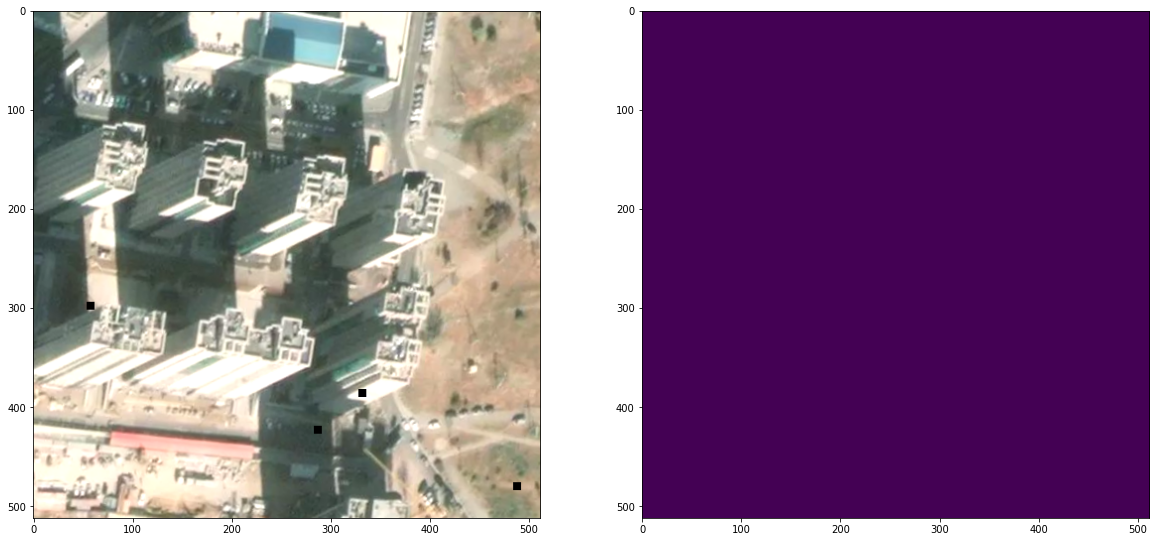

In [13]:
plot_random_dataset_item(train_dataset)

N= 19


<Figure size 864x1296 with 0 Axes>

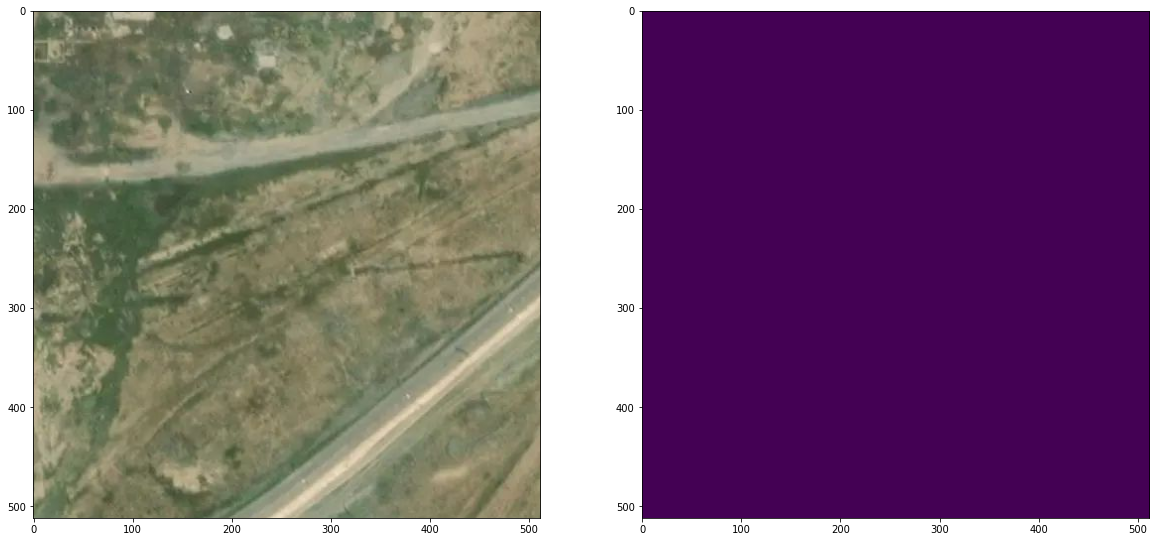

In [61]:
plot_random_dataset_item(valid_dataset)

In [15]:
CUDA = "cuda:0"
CPU = "cpu"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BEST_PATH = './best.pth'
LOG_PATH = './log.csv'

SKIP_ZERO_LABEL = False


class YModel(torch.nn.Module):
    def __init__(self):
        super(YModel, self).__init__()
        
        self.source_model = smp.Unet(
            encoder_name = 'timm-efficientnet-b1', 
            encoder_weights = 'imagenet', 
            classes = 2, 
            activation = None,
        )
        
        self.activation = torch.nn.Identity()

    def forward(self, x):
        x = x.float()

        x.div_(255.0)

        x[:,0, :, :].add_(-0.485)
        x[:,1, :, :].add_(-0.456)
        x[:,2, :, :].add_(-0.406)

        x[:,0, :, :].div_(0.229)
        x[:,1, :, :].div_(0.224)
        x[:,2, :, :].div_(0.225)
        
        x = self.source_model(x)
        x = self.activation(x)
        return x

NET = YModel()
NET = NET.to(DEVICE)
    
OPTIMIZER = torch.optim.Adam(NET.parameters(), lr=1e-4)

SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER,
                                                       factor=0.1,
                                                       patience=5,
                                                       mode='min')

# Imagenet normalization
jaccard_loss_f = smp.losses.jaccard.JaccardLoss(smp.losses.MULTICLASS_MODE,
                                                classes=None,
                                                from_logits=True)

CRITERION = lambda x, y: jaccard_loss_f(x, y.long())

TRAIN_LOADER = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_LOADER_WORKERS)
VALID_LOADER = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                           shuffle=False, num_workers=NUM_LOADER_WORKERS)

In [16]:
best_loss = float('inf')
valid_count = len(VALID_LOADER)
train_log = []
train_count = len(TRAIN_LOADER)

for epoch in range(1, EPOCH_COUNT+1):
    total_train_loss = 0.0
    with tqdm(TRAIN_LOADER, position=0) as train_data_iterator:
        for batch_n, data in enumerate(train_data_iterator, 1):
            progress_update = False
    
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(DEVICE).permute(0, 3, 1, 2), labels.to(DEVICE)

            OPTIMIZER.zero_grad()

            outputs = NET(inputs)

            loss = CRITERION(outputs, labels)
            loss.backward()
            OPTIMIZER.step()
            
            loss_value = float(loss.item())

            history_item = {'epoch': epoch,
                            'batch': batch_n,
                            'loss': loss_value}
            train_data_iterator.set_postfix(history_item)
            total_train_loss += loss_value

            if batch_n == train_count:
                avg_train_loss = total_train_loss / train_count
                
                total_valid_loss = 0.0
                with torch.no_grad():
                    for val_batch_n, valid_data in enumerate(VALID_LOADER):
                        valid_inputs, valid_labels = valid_data
                        valid_inputs, valid_labels = valid_inputs.to(DEVICE).permute(0, 3, 1, 2), valid_labels.to(DEVICE)
                        
                        valid_outputs = NET(valid_inputs)
                        loss_value = float(CRITERION(valid_outputs, valid_labels))
                        total_valid_loss += loss_value
                        train_data_iterator.set_postfix({'validation': '{}/{}'.format(str(val_batch_n), str(valid_count))})

                avg_valid_loss = total_valid_loss / len(VALID_LOADER)
                SCHEDULER.step(avg_valid_loss)

                if best_loss > avg_valid_loss:
                    best_loss = avg_valid_loss
                    torch.save(NET.state_dict(), BEST_PATH)
                train_log.append({'epoch': epoch,
                                  'tloss': avg_train_loss,
                                  'vloss': avg_valid_loss})

                with open(LOG_PATH, 'w', newline='') as f:
                    dw = csv.DictWriter(f, train_log[-1].keys())
                    dw.writeheader()
                    dw.writerows(train_log)
    
                train_data_iterator.set_postfix(train_log[-1])
                break
                

print('\nTraining fininshed!')

 99%|████▉| 103/104 [02:30<00:01,  1.46s/it, epoch=25, tloss=0.074, vloss=0.137]


Training fininshed!


N= 2


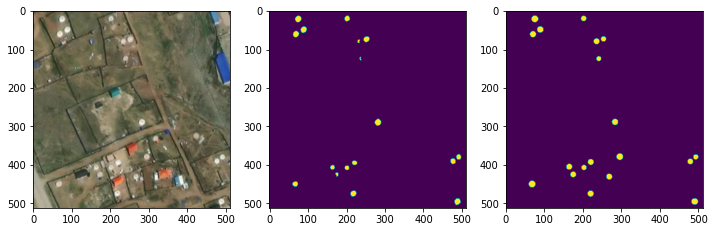

In [17]:
n = random.randint(0, len(valid_dataset)-1)
i = valid_dataset[n]
print('N=', n)
image, mask  = i

data = torch.unsqueeze(torch.from_numpy(image), dim=0)
data = data.to(DEVICE).permute(0, 3, 1, 2)

with torch.no_grad():
    pred = NET(data)
    pred = pred.log_softmax(dim=1).exp()

pred_mask = torch.squeeze(torch.argmax(pred, dim=1, keepdim=False)).contiguous().detach().cpu().numpy()
f, axarr = plt.subplots(1,3, figsize=(12, 22))
axarr[0].imshow(image)
axarr[1].imshow(pred_mask)
axarr[2].imshow(mask)
plt.show()